# Huffman Coding

Huffman coding is a widely used method for constructing prefix-free, binary codes based on symbol probabilities/frequencies. It is guaranteed to produce an optimal code that minimizes the expected codeword length.

In this notebook, we implement encoding, decoding, and length functions for Huffman coding.

# Imports

In [1]:
import heapq
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display

# Function Definitions

In this section, we define the core functions for Huffman coding:

- `huffman_tree`
- `get_huffman_code`
- `huffman_encode`
- `huffman_decode`
- `huffman_length`

The following helper dataclasses are used to build and manage the tree:

- `HeapNode`
- `SymbolNode`

## `HeapNode`

Represents a node in the heap, storing cumulative weight and child nodes.

In [2]:
@dataclass(order=True)
class HeapNode:
    weight: int
    nodes: list = field(compare=False)

## `SymbolNode`

Represents a leaf node for a symbol, storing the symbol and its code.

In [3]:
@dataclass
class SymbolNode:
    symbol: str
    code: str = ""

## Huffman Tree

Constructs the Huffman tree from symbol frequencies.

In [4]:
def huffman_tree(frequencies):
    heap = [
        HeapNode(weight=weight, nodes=[SymbolNode(symbol=symbol)])
        for symbol, weight in frequencies.items()
    ]
    heapq.heapify(heap)

    while len(heap) > 1:
        low = heapq.heappop(heap)
        high = heapq.heappop(heap)

        for node in low.nodes:
            node.code = "0" + node.code
        for node in high.nodes:
            node.code = "1" + node.code

        merged_node = HeapNode(weight=low.weight + high.weight, nodes=low.nodes + high.nodes)
        heapq.heappush(heap, merged_node)

    return sorted(
        heapq.heappop(heap).nodes,
        key=lambda node: (len(node.code), node.symbol)
    )

## Huffman Codes Dictionary

Produces a dictionary of Huffman codes for each symbol.  

In [5]:
def get_huffman_code(frequencies):
    tree = huffman_tree(frequencies)
    return {
        node.symbol: node.code
        for node in tree
    }

## Encoding

Encode a symbol or sequence of symbols using the Huffman code.

In [6]:
def huffman_encode(symbols, codes, collapse=True):
    if isinstance(symbols, str) and len(symbols) == 1:
        if symbols not in codes:
            raise ValueError(f"Unknown symbol: {symbols}")
        return codes[symbols]

    try:
        encoded = []
        for symbol in symbols:
            if symbol not in codes:
                raise ValueError(f"Unknown symbol: {symbol}")
            encoded.append(codes[symbol])

        return "".join(encoded) if collapse else encoded
    except TypeError:
        raise ValueError("Input must be a symbol or an iterable of symbols")

## Decoding

Decode Huffman codeword or a sequence of codewords into their corresponding symbols.

In [7]:
def huffman_decode(code, codes, as_list=False):
    decode_map = {
        code : symbol
        for symbol, code in codes.items()
    }
    max_codeword_len = max(map(len,decode_map))

    index = 0
    results = list()
    while index < len(code):
        for end in range(index + 1, min(index + max_codeword_len, len(code)) + 1):
            prefix = code[index:end]
            if prefix in decode_map:
                index = end
                results.append( decode_map[prefix] )
                break
        else:
            raise ValueError(f"Malformed Huffman code at index {index}")

    return results if as_list or len(results) > 1 else results[0]

## Code Lengths

Return the length of the Huffman codeword for the given symbol.

In [8]:
def huffman_length(symbols, codes, as_list=False):
    def _huffman_length(symbol):
        if symbol not in codes:
            raise ValueError(f"Unknown symbol: {symbol}")
        return len(codes[symbol])

    # Single symbol
    if isinstance(symbols, str) and len(symbols) == 1:
        return _huffman_length(symbols) if not as_list else [_huffman_length(symbols)]

    # Sequence of symbols
    try:
        return [_huffman_length(symbol) for symbol in symbols]
    except TypeError:
        raise ValueError("Input must be a symbol or an iterable of symbols")

# Example Usage

In [9]:
symbol_probs = {
    "a": 0.05,
    "b": 0.15,
    "c": 0.4,
    "d": 0.25,
    "e": 0.15
}
symbols = sorted(symbol_probs)
huffman_code = get_huffman_code(symbol_probs)

messages = symbols + ["acdc"]
encoded = [huffman_encode(message, huffman_code) for message in messages]
decoded = [huffman_decode(code, huffman_code) for code in encoded]
lengths = [huffman_length(message, huffman_code) for message in messages]
probs = [np.prod([symbol_probs[symbol] for symbol in message]) for message in messages]


results_df = pd.DataFrame(
    list(zip(encoded, decoded, lengths, probs)),
    index=pd.Index(messages, name="Message"),
    columns=[
        "Huffman Codeword", "Decoded", "Codeword Length(s)", "Probability"
    ]
)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(results_df)

,Huffman Codeword,Decoded,Codeword Length(s),Probability
Message,,,,
a,1110,a,4,0.050
b,110,b,3,0.150
c,0,c,1,0.400
d,10,d,2,0.250
e,1111,e,4,0.150
acdc,11100100,"[a, c, d, c]","[4, 1, 2, 1]",0.002


# Visualizing Huffman Code Lengths

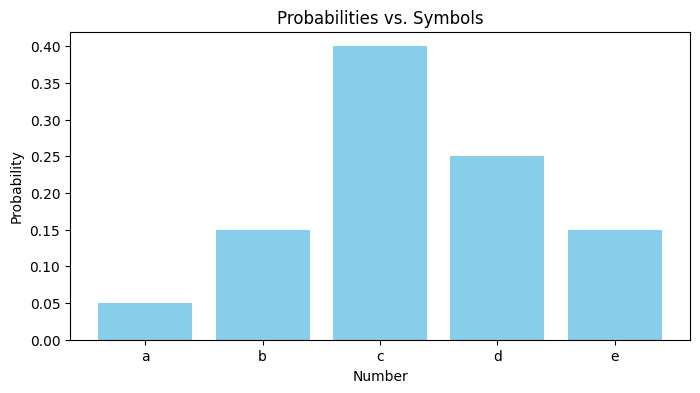

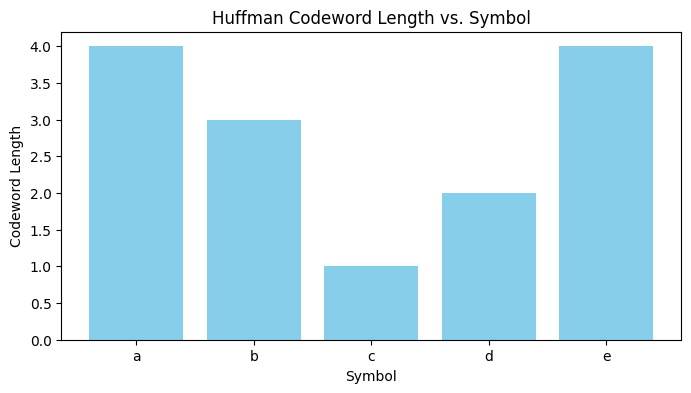

In [12]:
code_lengths = [huffman_length(symbol, huffman_code) for symbol in symbols]

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(symbol_probs.keys(), symbol_probs.values(), color="skyblue")
ax.set_xlabel("Number")
ax.set_ylabel("Probability")
ax.set_title("Probabilities vs. Symbols")
ax.set_xticks(list(symbol_probs.keys()))
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(symbols, code_lengths, color="skyblue")
ax.set_xlabel("Symbol")
ax.set_ylabel("Codeword Length")
ax.set_title("Huffman Codeword Length vs. Symbol")
plt.show()